# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
# Your code here
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

Type is the column we want to predict 

In [5]:
websites.Type.value_counts()

0    1565
1     216
Name: Type, dtype: int64

Based on the count of values in Type column, we can say that type 1 are malicious

Your comment here     
1. Apart from Content_lenght, all columns have really few nans
2. Columns 8 and 9 could be change has datetime
3. All columns with numbers are numeric

#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [6]:
#Selection of the numeric features of the dataset
websites_numeric = websites.select_dtypes(np.number)
websites_numeric.drop('Type', axis = 1, inplace = True)
websites_numeric.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0


In [7]:
#Plotting the heatmap. I have written it as a function as we will reuse it a few times later
def my_correlation(df_numerical):
    
    #Correlation matrix:
    correlation = np.abs(df_numerical.corr())

    #Only the lower triange
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    #Setting size of the figure
    plt.subplots(figsize=(14, 14))

    #Plotting
    sns.heatmap(correlation, mask=mask,annot = True, cmap = 'RdYlGn')
    plt.show()

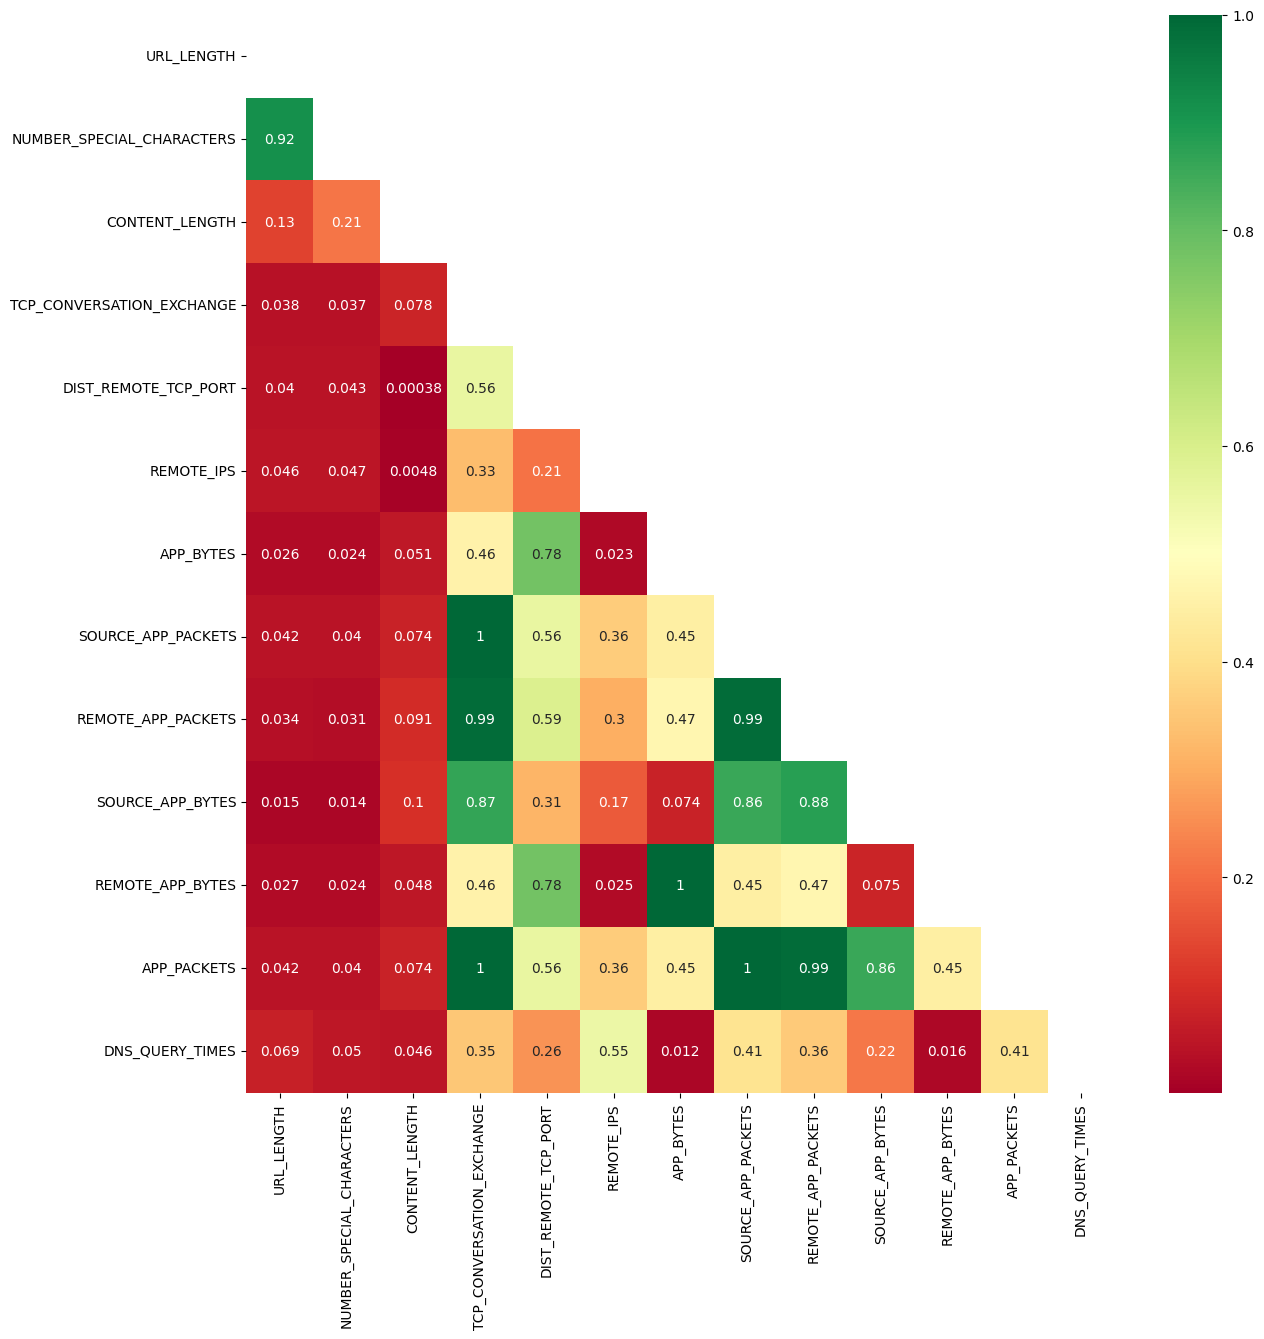

In [8]:
my_correlation(websites_numeric)

# Your comment here
By looking at the heatmap above, I am thinking to remove 'TCP Conversation exchange', 'App packets', and probably 'Source app packets'

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [9]:
# Your code here
#I am starting by removing the one that as collinearity with the most columns, which is TCP Conversation Exchange

websites_numeric.drop(['TCP_CONVERSATION_EXCHANGE'], axis = 1, inplace= True)
websites_numeric.head(5)

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,16,7,263.0,0,2,700,9,10,1153,832,9,2.0
1,16,6,15087.0,7,4,1230,17,19,1265,1230,17,0.0
2,16,6,324.0,0,0,0,0,0,0,0,0,0.0
3,17,6,162.0,22,3,3812,39,37,18784,4380,39,8.0
4,17,6,124140.0,2,5,4278,61,62,129889,4586,61,4.0


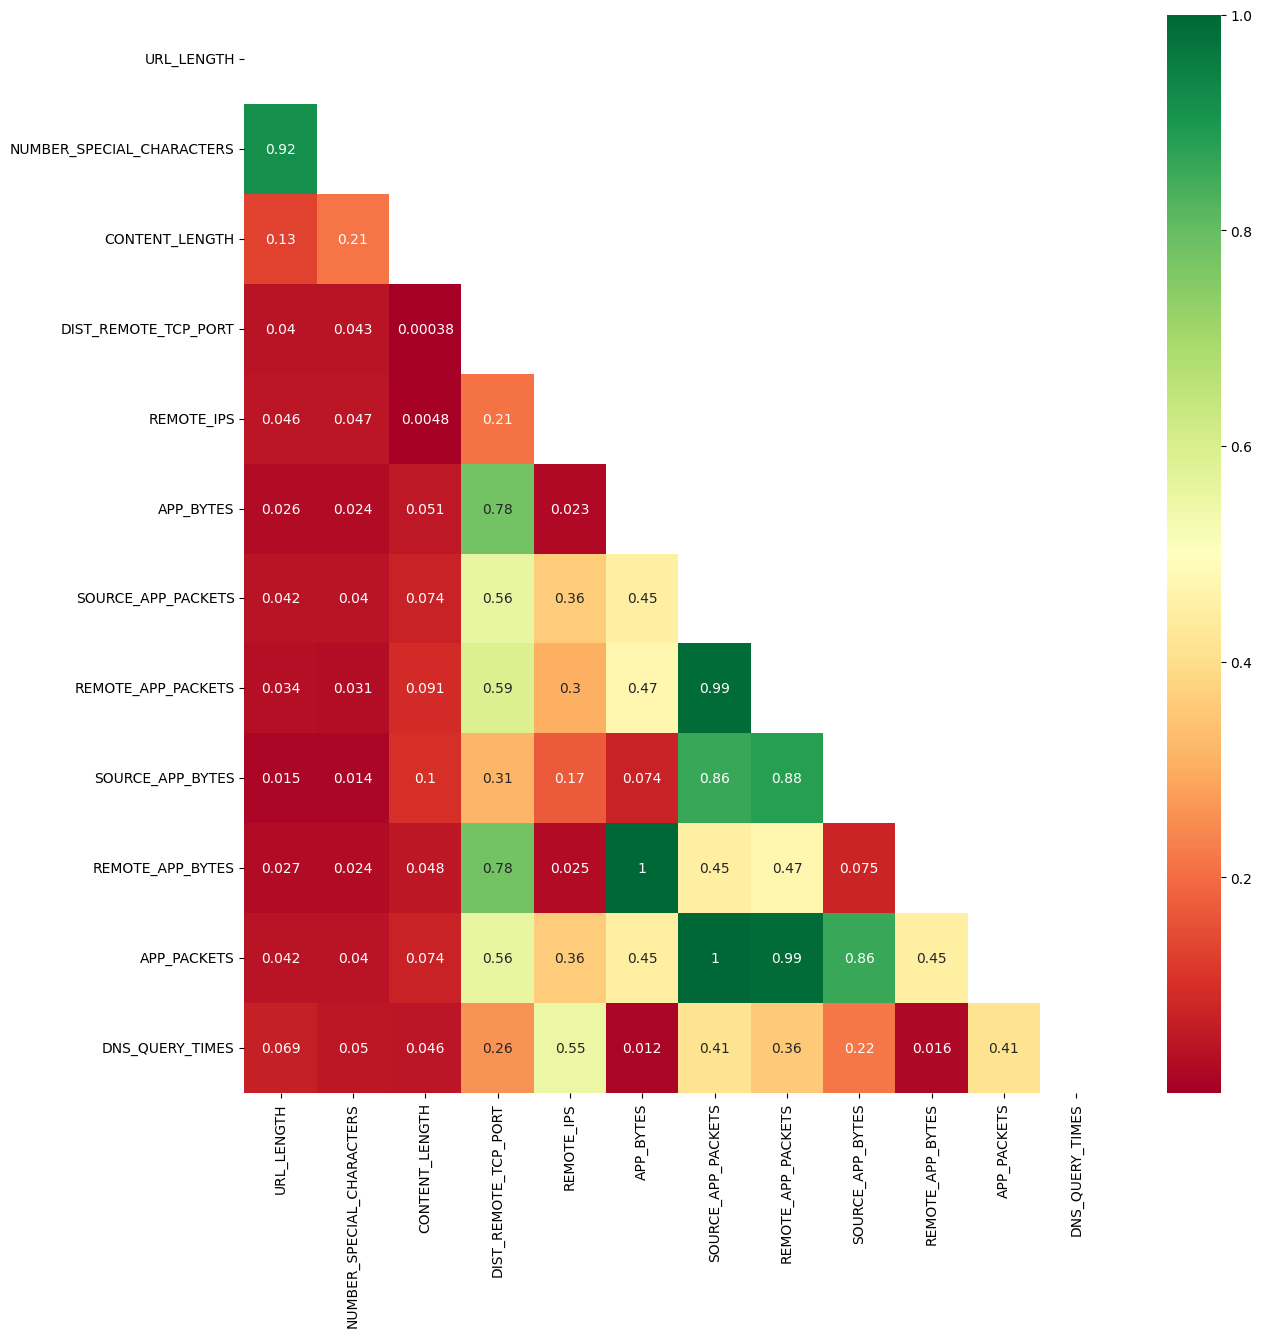

In [10]:
my_correlation(websites_numeric)

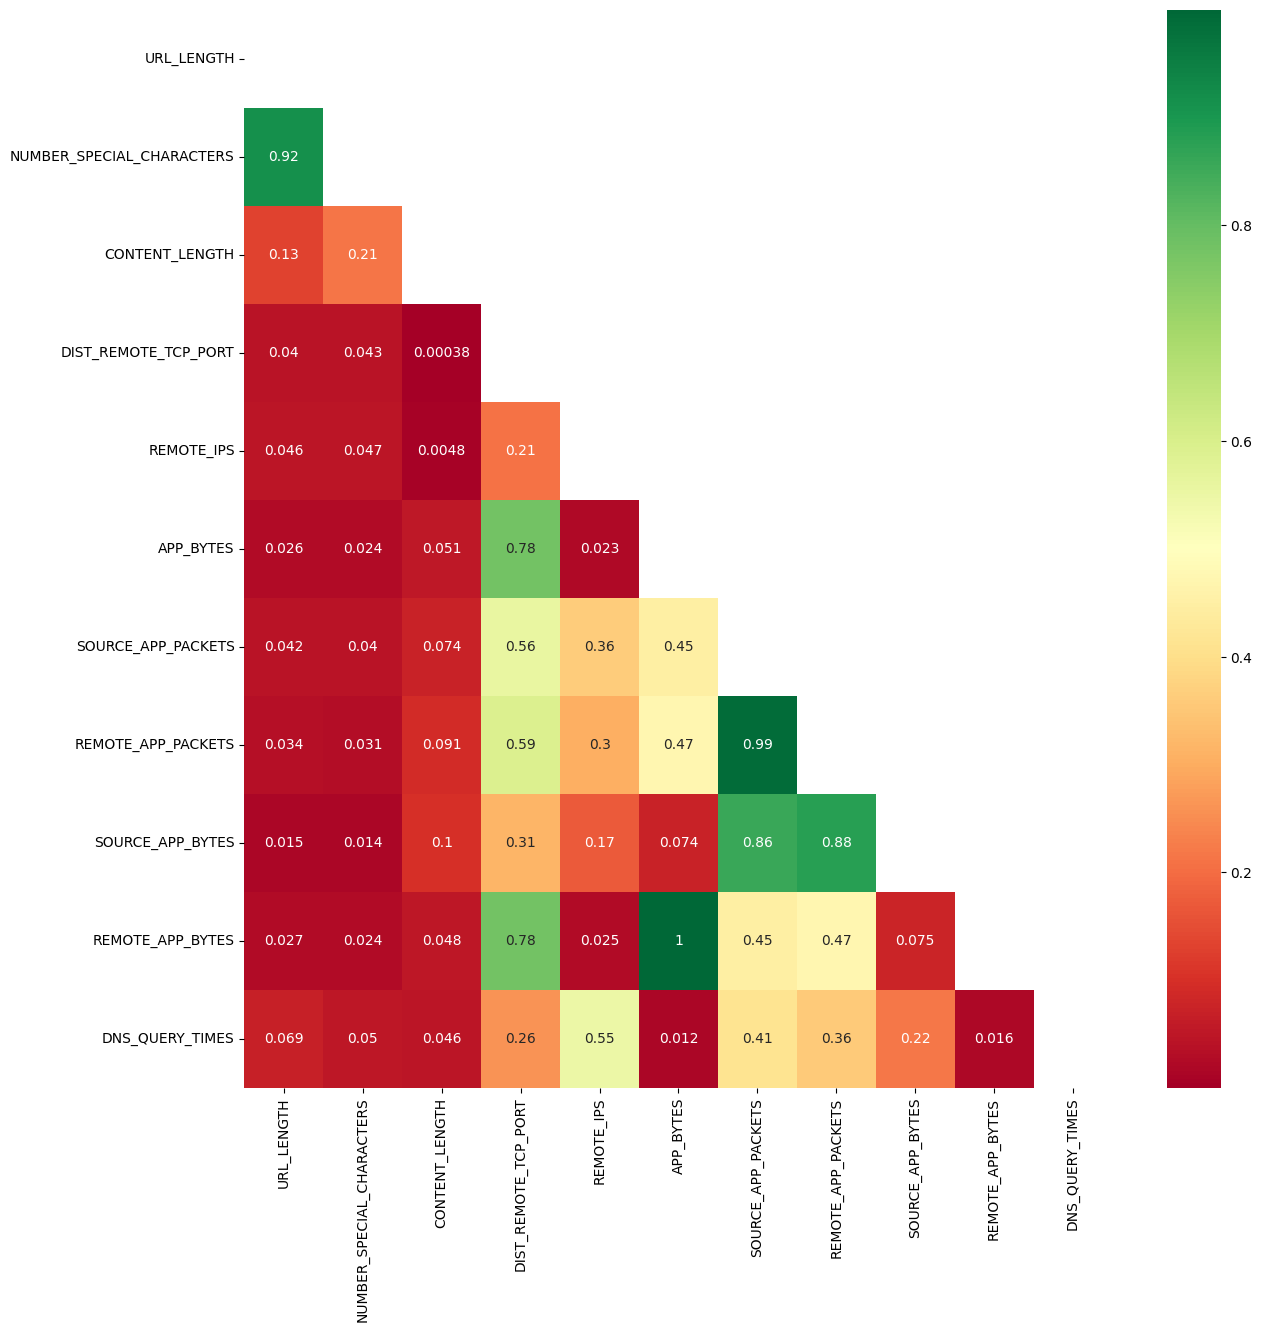

In [11]:
#Better resuts, but we keep dropping columns. Next is 'App Packets'

websites_numeric.drop(['APP_PACKETS'], axis = 1, inplace= True)
websites_numeric.head(5)
my_correlation(websites_numeric)

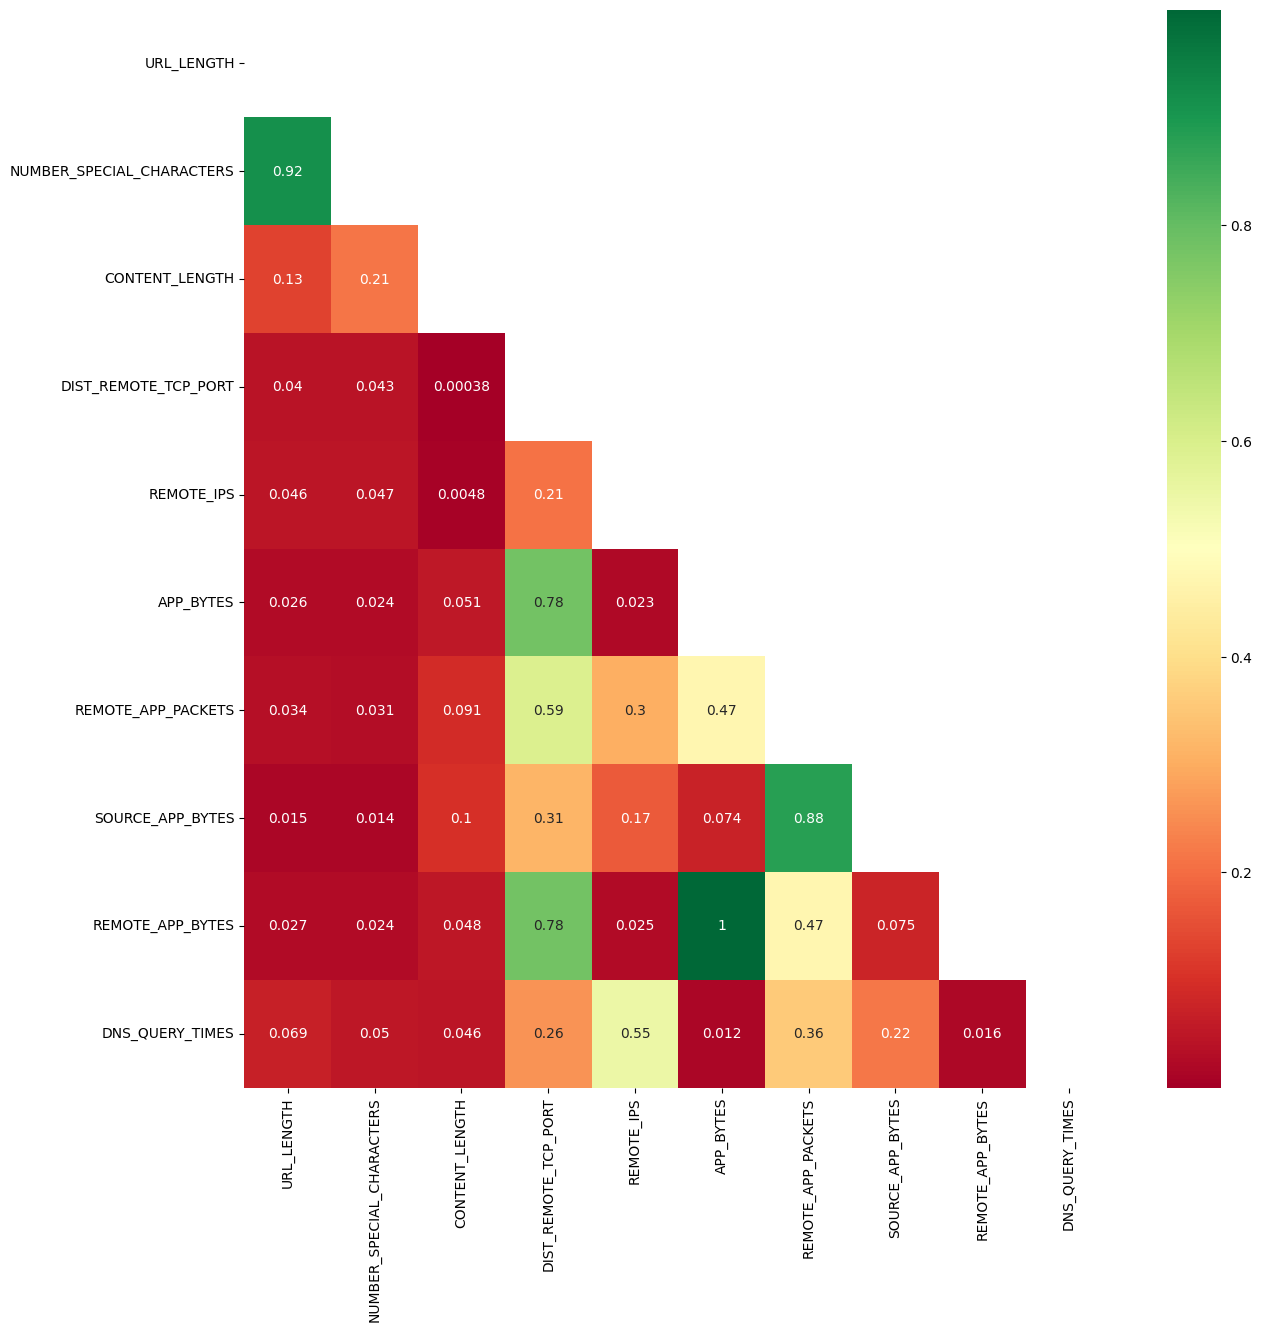

In [12]:
#Next one on the list is 'Source App Packets'

websites_numeric.drop(['SOURCE_APP_PACKETS'], axis = 1, inplace= True)
websites_numeric.head(5)
my_correlation(websites_numeric)

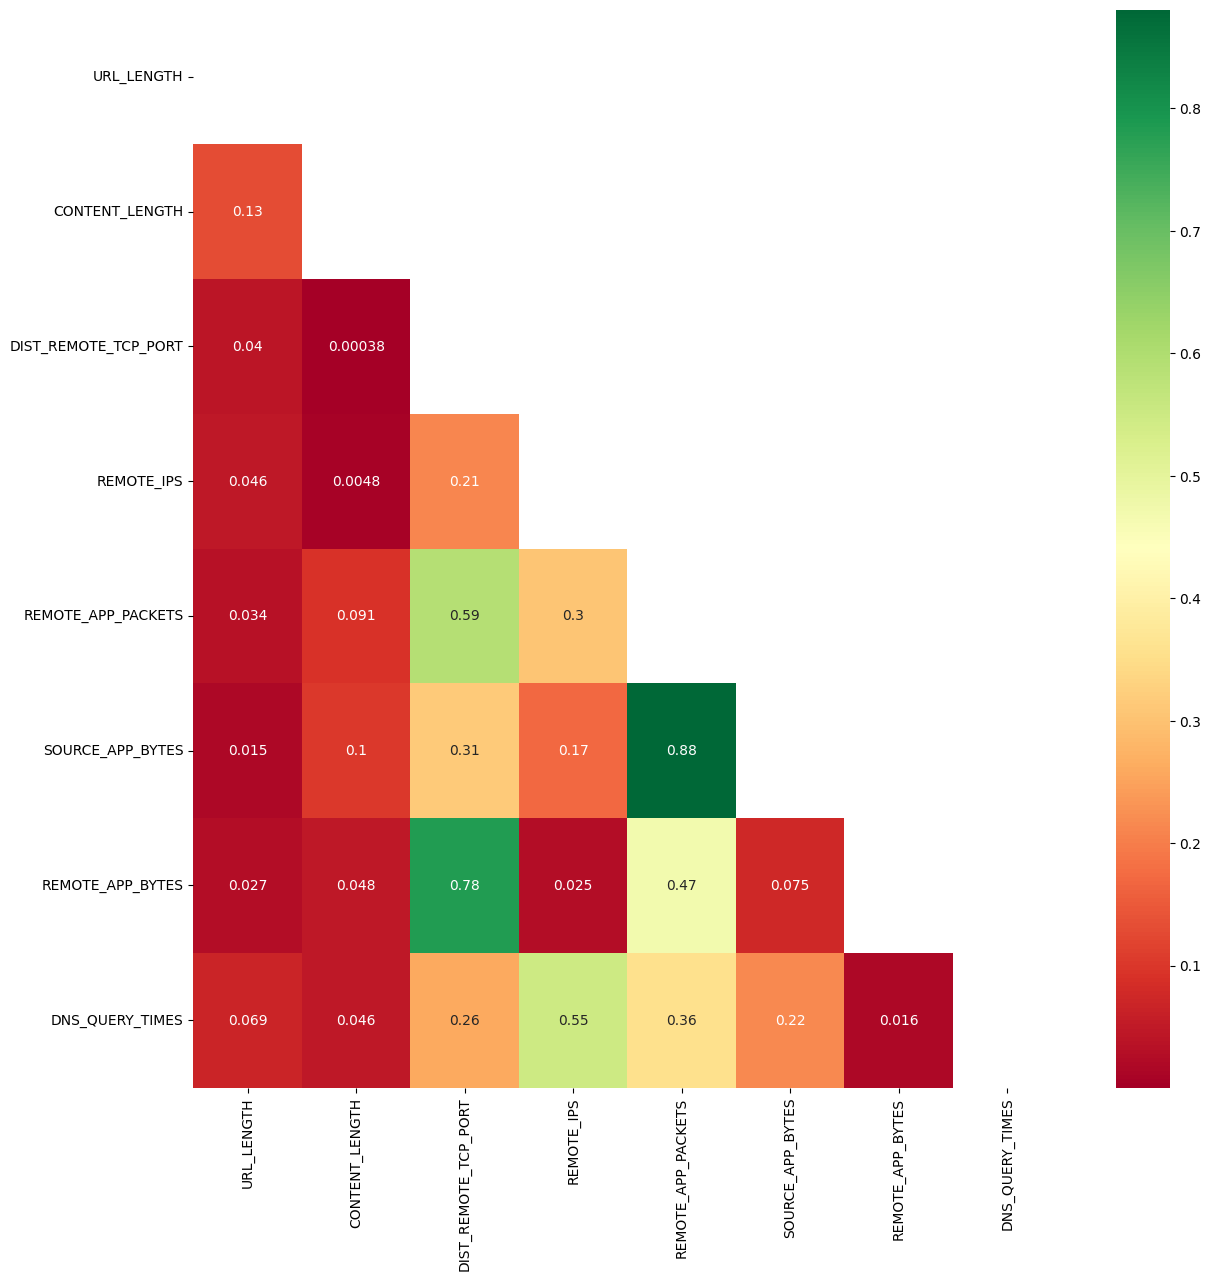

In [13]:
#We still have 2 values above 90%. We will remove them at the same time

websites_numeric.drop(['NUMBER_SPECIAL_CHARACTERS', 'APP_BYTES' ], axis = 1, inplace= True)
websites_numeric.head(5)
my_correlation(websites_numeric)

It is much less green now! There is still 0.88 Colinearity at some point. If results at the end arn't as good as expected, we will drop it, but for now we keep it

In [14]:
#I am now dropping these columns from the original dataset

websites = websites.drop(['TCP_CONVERSATION_EXCHANGE', 'APP_PACKETS','SOURCE_APP_PACKETS', 'NUMBER_SPECIAL_CHARACTERS', 'APP_BYTES'], axis = 1)

In [15]:
websites.head()

,URL,URL_LENGTH,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,16,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,0,2,10,1153,832,2.0,1
1,B0_2314,16,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,7,4,19,1265,1230,0.0,0
2,B0_911,16,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0.0,0
3,B0_113,17,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,22,3,37,18784,4380,8.0,0
4,B0_403,17,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,2,5,62,129889,4586,4.0,0


# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [16]:
# Your code here
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL                   1781 non-null   object 
 1   URL_LENGTH            1781 non-null   int64  
 2   CHARSET               1781 non-null   object 
 3   SERVER                1780 non-null   object 
 4   CONTENT_LENGTH        969 non-null    float64
 5   WHOIS_COUNTRY         1781 non-null   object 
 6   WHOIS_STATEPRO        1781 non-null   object 
 7   WHOIS_REGDATE         1781 non-null   object 
 8   WHOIS_UPDATED_DATE    1781 non-null   object 
 9   DIST_REMOTE_TCP_PORT  1781 non-null   int64  
 10  REMOTE_IPS            1781 non-null   int64  
 11  REMOTE_APP_PACKETS    1781 non-null   int64  
 12  SOURCE_APP_BYTES      1781 non-null   int64  
 13  REMOTE_APP_BYTES      1781 non-null   int64  
 14  DNS_QUERY_TIMES       1780 non-null   float64
 15  Type                 

In [17]:
'''Here we can see that 'Content_Lenght' is missing a lot of values, almost 50%. 2 others columns are missing only 1 value'''

"Here we can see that 'Content_Lenght' is missing a lot of values, almost 50%. 2 others columns are missing only 1 value"

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [18]:
'''What we will do now is to drop 'Content_lenght' and to drop the row where 'Server' and 'DNS Query Times' are empty'''

"What we will do now is to drop 'Content_lenght' and to drop the row where 'Server' and 'DNS Query Times' are empty"

In [19]:
#Dropping 'Content_length'
websites.drop(['CONTENT_LENGTH'], axis = 1, inplace= True)
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL                   1781 non-null   object 
 1   URL_LENGTH            1781 non-null   int64  
 2   CHARSET               1781 non-null   object 
 3   SERVER                1780 non-null   object 
 4   WHOIS_COUNTRY         1781 non-null   object 
 5   WHOIS_STATEPRO        1781 non-null   object 
 6   WHOIS_REGDATE         1781 non-null   object 
 7   WHOIS_UPDATED_DATE    1781 non-null   object 
 8   DIST_REMOTE_TCP_PORT  1781 non-null   int64  
 9   REMOTE_IPS            1781 non-null   int64  
 10  REMOTE_APP_PACKETS    1781 non-null   int64  
 11  SOURCE_APP_BYTES      1781 non-null   int64  
 12  REMOTE_APP_BYTES      1781 non-null   int64  
 13  DNS_QUERY_TIMES       1780 non-null   float64
 14  Type                  1781 non-null   int64  
dtypes: float64(1), int64(

In [20]:
#Dropping the row where 'Server' and 'DNS Query Times' are empty
websites.dropna(inplace = True)
websites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL                   1779 non-null   object 
 1   URL_LENGTH            1779 non-null   int64  
 2   CHARSET               1779 non-null   object 
 3   SERVER                1779 non-null   object 
 4   WHOIS_COUNTRY         1779 non-null   object 
 5   WHOIS_STATEPRO        1779 non-null   object 
 6   WHOIS_REGDATE         1779 non-null   object 
 7   WHOIS_UPDATED_DATE    1779 non-null   object 
 8   DIST_REMOTE_TCP_PORT  1779 non-null   int64  
 9   REMOTE_IPS            1779 non-null   int64  
 10  REMOTE_APP_PACKETS    1779 non-null   int64  
 11  SOURCE_APP_BYTES      1779 non-null   int64  
 12  REMOTE_APP_BYTES      1779 non-null   int64  
 13  DNS_QUERY_TIMES       1779 non-null   float64
 14  Type                  1779 non-null   int64  
dtypes: float64(1), int64(

In [21]:
'''We can now see that all the feature are filled'''

'We can now see that all the feature are filled'

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [22]:
# Examine missing values in each column
# See above

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [23]:
# Your code here
websites['WHOIS_COUNTRY'].unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [24]:
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'UK' if x in ['GB', 'United Kingdom', "[u'GB'; u'UK']"] else x)
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'US' if x == 'us' else x)
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'CY' if x == 'Cyprus' else x)
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'SE' if x == 'se' else x)
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'RU' if x == 'ru' else x)

In [25]:
websites['WHOIS_COUNTRY'].unique()

array(['None', 'US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK', 'UA',
       'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [26]:
# Your code here
print(len(websites['WHOIS_COUNTRY'].value_counts()))
websites['WHOIS_COUNTRY'].value_counts()

43


US      1105
None     306
CA        83
ES        63
UK        35
AU        35
PA        21
JP        11
CN        10
IN        10
FR         9
CZ         9
NL         6
CH         6
RU         6
KR         5
AT         4
SE         4
BS         4
PH         4
BE         3
HK         3
TR         3
DE         3
KY         3
SC         3
UA         2
CY         2
UY         2
KG         2
BR         2
NO         2
IL         2
SI         2
LV         1
PK         1
IT         1
LU         1
BY         1
AE         1
IE         1
UG         1
TH         1
Name: WHOIS_COUNTRY, dtype: int64

In [27]:
'''A bar chart would be surely more good to look at. But it will not tell us how many unique value there is as we need to now. Indeed, with 43 uniques values, we cannot keep this columns as it is. We can also note that for a faire amount (306) we do not know the country'''

'A bar chart would be surely more good to look at. But it will not tell us how many unique value there is as we need to now. Indeed, with 43 uniques values, we cannot keep this columns as it is. We can also note that for a faire amount (306) we do not know the country'

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [28]:
# Your code here
country_top_10 = websites['WHOIS_COUNTRY'].value_counts().head(10)

In [29]:
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x : 'OTHER' if x not in country_top_10 else x)

In [30]:
websites['WHOIS_COUNTRY'].value_counts()

US       1105
None      306
OTHER     100
CA         83
ES         63
UK         35
AU         35
PA         21
JP         11
IN         10
CN         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [31]:
# Your code here
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis = 1, inplace = True)
websites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL                   1779 non-null   object 
 1   URL_LENGTH            1779 non-null   int64  
 2   CHARSET               1779 non-null   object 
 3   SERVER                1779 non-null   object 
 4   WHOIS_COUNTRY         1779 non-null   object 
 5   DIST_REMOTE_TCP_PORT  1779 non-null   int64  
 6   REMOTE_IPS            1779 non-null   int64  
 7   REMOTE_APP_PACKETS    1779 non-null   int64  
 8   SOURCE_APP_BYTES      1779 non-null   int64  
 9   REMOTE_APP_BYTES      1779 non-null   int64  
 10  DNS_QUERY_TIMES       1779 non-null   float64
 11  Type                  1779 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 180.7+ KB


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [32]:
# Your code here
websites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL                   1779 non-null   object 
 1   URL_LENGTH            1779 non-null   int64  
 2   CHARSET               1779 non-null   object 
 3   SERVER                1779 non-null   object 
 4   WHOIS_COUNTRY         1779 non-null   object 
 5   DIST_REMOTE_TCP_PORT  1779 non-null   int64  
 6   REMOTE_IPS            1779 non-null   int64  
 7   REMOTE_APP_PACKETS    1779 non-null   int64  
 8   SOURCE_APP_BYTES      1779 non-null   int64  
 9   REMOTE_APP_BYTES      1779 non-null   int64  
 10  DNS_QUERY_TIMES       1779 non-null   float64
 11  Type                  1779 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 180.7+ KB


#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [33]:
#Curiosity to look at how many unique values
len(websites.URL.unique())

1779

In [34]:
# Your code here
websites.drop(['URL'], axis = 1, inplace = True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [35]:
# Your code here
websites.CHARSET.unique()

array(['iso-8859-1', 'UTF-8', 'us-ascii', 'ISO-8859-1', 'utf-8', 'None',
       'windows-1251', 'ISO-8859', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [36]:
# Your code here
websites.SERVER.unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

In [37]:
"""The first hypothsis that comes to me is to keep the first word : 'nginx', 'Apache', 'Microsoft', 'mw'. If it dosnt'start by one of these 4, we classify it as other"""

"The first hypothsis that comes to me is to keep the first word : 'nginx', 'Apache', 'Microsoft', 'mw'. If it dosnt'start by one of these 4, we classify it as other"

![Think Hard](../images/think-hard.jpg)

# Your comment here


Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [38]:
# Your code here
websites['SERVER'] = websites['SERVER'].apply(lambda x : 'Microsoft' if 'Microsoft' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x : 'Apache' if 'Apache' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x : 'nginx' if 'nginx' in x else x)
websites['SERVER'] = websites['SERVER'].apply(lambda x : 'Other' if x not in ['Microsoft', 'Apache', 'nginx'] else x)
websites['SERVER'].unique()

array(['nginx', 'Apache', 'Microsoft', 'Other'], dtype=object)

In [39]:
# Count `SERVER` value counts here
websites['SERVER'].value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [40]:
# Your code here
websites_dummmy = pd.get_dummies(websites, drop_first=False)

In [41]:
websites_dummmy.head()

,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Apache,SERVER_Microsoft,SERVER_Other,SERVER_nginx,WHOIS_COUNTRY_AU,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,16,0,2,10,1153,832,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,16,7,4,19,1265,1230,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,16,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,17,22,3,37,18784,4380,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,17,2,5,62,129889,4586,4.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [42]:
# Your code here
websites_dummmy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URL_LENGTH            1779 non-null   int64  
 1   DIST_REMOTE_TCP_PORT  1779 non-null   int64  
 2   REMOTE_IPS            1779 non-null   int64  
 3   REMOTE_APP_PACKETS    1779 non-null   int64  
 4   SOURCE_APP_BYTES      1779 non-null   int64  
 5   REMOTE_APP_BYTES      1779 non-null   int64  
 6   DNS_QUERY_TIMES       1779 non-null   float64
 7   Type                  1779 non-null   int64  
 8   CHARSET_ISO-8859      1779 non-null   uint8  
 9   CHARSET_ISO-8859-1    1779 non-null   uint8  
 10  CHARSET_None          1779 non-null   uint8  
 11  CHARSET_UTF-8         1779 non-null   uint8  
 12  CHARSET_iso-8859-1    1779 non-null   uint8  
 13  CHARSET_us-ascii      1779 non-null   uint8  
 14  CHARSET_utf-8         1779 non-null   uint8  
 15  CHARSET_windows-1251 

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [43]:
websites_dummmy.Type

0       1
1       0
2       0
3       0
4       0
       ..
1776    1
1777    1
1778    0
1779    0
1780    0
Name: Type, Length: 1779, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

# Your code here:
features = websites_dummmy.drop('Type', axis = 1)
target = websites_dummmy.Type

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [45]:
'''I need to standardize the values'''

'I need to standardize the values'

In [46]:
normalizer = MinMaxScaler()
X_train_numeric = X_train.select_dtypes(np.number)
normalizer = normalizer.fit(X_train_numeric)

In [47]:
X_train_normalized = normalizer.transform(X_train_numeric)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train_numeric.columns)
X_train_normalized.head()

,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Apache,SERVER_Microsoft,SERVER_Other,SERVER_nginx,WHOIS_COUNTRY_AU,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,0.416309,0.008475,0.176471,0.007009,0.000289,0.000256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.090129,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.145923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.128755,0.000000,0.117647,0.007788,0.000613,0.000377,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.716738,0.002825,0.411765,0.020249,0.003962,0.001160,0.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
X_test_numeric = X_test.select_dtypes(np.number)
X_test_normalized = normalizer.transform(X_test_numeric)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test_numeric.columns)
X_test_normalized.head()

,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Apache,SERVER_Microsoft,SERVER_Other,SERVER_nginx,WHOIS_COUNTRY_AU,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,0.111588,0.000000,0.352941,0.013240,0.002869,0.000988,0.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.115880,0.000000,0.176471,0.009346,0.001063,0.000464,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.081545,0.056497,0.352941,0.039720,0.012677,0.003322,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.051502,0.005650,0.176471,0.006231,0.000297,0.000234,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.145923,0.000000,0.117647,0.009346,0.000732,0.000545,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [49]:
# Your code here:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X_train_normalized, y_train)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [50]:
# Your code here:


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [51]:
# Your code here:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = model.predict(X_test_normalized)

print("Accuracy :", round(accuracy_score(y_test,y_pred),4))

confus_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
confus_matrix.rename({0: 'Benign website - Prediction', 1: 'Malicious website - Prediction'}, axis=1, inplace=True)
confus_matrix.rename({0: 'Benign website - True', 1: 'Malicious website - True'}, axis=0, inplace=True)
confus_matrix

Accuracy : 0.9236


,Benign website - Prediction,Malicious website - Prediction
Benign website - True,389,2
Malicious website - True,32,22


What are your thoughts on the performance of the model? Write your conclusions below.

In [52]:
# Your conclusions here:
'''
We have a pretty good recall of 22 / (22 + 2) = .916 on this model, which means that the model doesn't miss when it is malicious.
But the precision is 22 / (32 + 22) = .407, means that more than half time the model doesn't know if the website is Malicious or not
'''


"\nWe have a pretty good recall of 22 / (22 + 2) = .916 on this model, which means that the model doesn't miss when it is malicious.\nBut the precision is 22 / (32 + 22) = .407, means that more than half time the model doesn't know if the website is Malicious or not\n"

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [53]:
X_test_normalized.isna().sum()

URL_LENGTH              0
DIST_REMOTE_TCP_PORT    0
REMOTE_IPS              0
REMOTE_APP_PACKETS      0
SOURCE_APP_BYTES        0
REMOTE_APP_BYTES        0
DNS_QUERY_TIMES         0
CHARSET_ISO-8859        0
CHARSET_ISO-8859-1      0
CHARSET_None            0
CHARSET_UTF-8           0
CHARSET_iso-8859-1      0
CHARSET_us-ascii        0
CHARSET_utf-8           0
CHARSET_windows-1251    0
CHARSET_windows-1252    0
SERVER_Apache           0
SERVER_Microsoft        0
SERVER_Other            0
SERVER_nginx            0
WHOIS_COUNTRY_AU        0
WHOIS_COUNTRY_CA        0
WHOIS_COUNTRY_CN        0
WHOIS_COUNTRY_ES        0
WHOIS_COUNTRY_IN        0
WHOIS_COUNTRY_JP        0
WHOIS_COUNTRY_None      0
WHOIS_COUNTRY_OTHER     0
WHOIS_COUNTRY_PA        0
WHOIS_COUNTRY_UK        0
WHOIS_COUNTRY_US        0
dtype: int64

In [54]:
!pip install threadpoolctl==3.1.0

In [55]:
# Your code here:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

normalizer = MinMaxScaler()
X_train_numeric = X_train.select_dtypes(np.number)
normalizer.fit(X_train_numeric)

X_train_normalized = normalizer.transform(X_train_numeric)
#X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train_numeric.columns)

X_test_normalized = normalizer.transform(X_test_numeric)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test_numeric.columns)

model_k3 = KNeighborsClassifier(n_neighbors=3)

model_k3.fit(X_train_normalized, y_train)

y_pred_k3 = model_k3.predict(X_test_normalized)

c:\Users\misol\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [60]:
# Your code here:
model_k3.predict(X_test_normalized)

c:\Users\misol\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [61]:
np.array(y_test)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [62]:
accuracy_score(model_k3.predict(X_test_normalized),np.array(y_test))

c:\Users\misol\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9370786516853933

In [63]:
confus_matrix_k3 = pd.DataFrame(confusion_matrix(y_test, y_pred_k3))
confus_matrix_k3.rename({0: 'Benign website - Prediction', 1: 'Malicious website - Prediction'}, axis=1, inplace=True)
confus_matrix_k3.rename({0: 'Benign website - True', 1: 'Malicious website - True'}, axis=0, inplace=True)
confus_matrix_k3

,Benign website - Prediction,Malicious website - Prediction
Benign website - True,379,12
Malicious website - True,16,38


#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [64]:
# Your code here:
from sklearn.neighbors import KNeighborsClassifier
model_k5 = KNeighborsClassifier(n_neighbors=5)

model_k5 = model_k5.fit(X_train_normalized, y_train)

y_pred_k5 = model_k5.predict(X_test_normalized)

c:\Users\misol\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [65]:
# Your conclusions here:
accuracy_score(model_k5.predict(X_test_normalized),np.array(y_test))


c:\Users\misol\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9280898876404494

In [66]:
confus_matrix_k5 = pd.DataFrame(confusion_matrix(y_test, y_pred_k5))
confus_matrix_k5.rename({0: 'Benign website - Prediction', 1: 'Malicious website - Prediction'}, axis=1, inplace=True)
confus_matrix_k5.rename({0: 'Benign website - True', 1: 'Malicious website - True'}, axis=0, inplace=True)
confus_matrix_k5

,Benign website - Prediction,Malicious website - Prediction
Benign website - True,375,16
Malicious website - True,16,38


# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here